In [22]:
# # Modelagem - Predição de evolução (óbito vs não óbito) em SRAG
#
# Objetivo:
# - Treinar modelos para prever EVOLUCAO_BIN (0=cura, 1=óbito)
# - Usar variáveis selecionadas da EDA (demográficas, comorbidades, gravidade etc.)
# - Avaliar com métricas robustas e transparência no passo a passo

In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [24]:
# Caminhos Utilizados
PROJECT_ROOT = Path.cwd().parent        # sobe um nível

DATA_PROCESSED = PROJECT_ROOT / "srag_2023_analysis" / "data" / "processed" 
CSV_PATH = DATA_PROCESSED / "df_tipado.csv"

In [25]:
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Shape inicial:", df.shape)

Shape inicial: (279453, 176)


In [26]:
# Garantir tipos básicos
df["EVOLUCAO_BIN"] = pd.to_numeric(df["EVOLUCAO_BIN"], errors="coerce")
df["EVOLUCAO_disponivel"] = pd.to_numeric(df["EVOLUCAO_disponivel"], errors="coerce")

In [27]:
# Filtrar apenas casos com desfecho disponível
df_model = df.loc[df["EVOLUCAO_disponivel"] == 1].copy()
df_model = df_model.loc[df_model["EVOLUCAO_BIN"].isin([0, 1])]

In [28]:
# === Engenharia de variáveis para modelagem ===

# 1. Região a partir da UF
df["SG_UF_NOT"] = df["SG_UF_NOT"].astype(str).str.upper().str.strip()

REGIAO_MAP = {
    "AC": "N", "AP": "N", "AM": "N", "PA": "N", "RO": "N", "RR": "N", "TO": "N",
    "AL": "NE", "BA": "NE", "CE": "NE", "MA": "NE", "PB": "NE", "PE": "NE",
    "PI": "NE", "RN": "NE", "SE": "NE",
    "ES": "SE", "MG": "SE", "RJ": "SE", "SP": "SE",
    "PR": "S", "RS": "S", "SC": "S",
    "DF": "CO", "GO": "CO", "MS": "CO", "MT": "CO",
}
df["REGIAO"] = df["SG_UF_NOT"].map(REGIAO_MAP)

# 2. Capital x interior
df["ID_MN_RESI"] = df["ID_MN_RESI"].astype(str).str.upper().str.strip()

CAPITAIS_POR_UF = {
    "AC": "RIO BRANCO",
    "AL": "MACEIO",
    "AM": "MANAUS",
    "AP": "MACAPA",
    "BA": "SALVADOR",
    "CE": "FORTALEZA",
    "DF": "BRASILIA",
    "ES": "VITORIA",
    "GO": "GOIANIA",
    "MA": "SAO LUIS",
    "MG": "BELO HORIZONTE",
    "MS": "CAMPO GRANDE",
    "MT": "CUIABA",
    "PA": "BELEM",
    "PB": "JOAO PESSOA",
    "PE": "RECIFE",
    "PI": "TERESINA",
    "PR": "CURITIBA",
    "RJ": "RIO DE JANEIRO",
    "RN": "NATAL",
    "RO": "PORTO VELHO",
    "RR": "BOA VISTA",
    "RS": "PORTO ALEGRE",
    "SC": "FLORIANOPOLIS",
    "SE": "ARACAJU",
    "SP": "SAO PAULO",
    "TO": "PALMAS",
}

df["TIPO_MUN"] = np.where(
    (df["SG_UF_NOT"].isin(CAPITAIS_POR_UF.keys())) &
    (df["ID_MN_RESI"] == df["SG_UF_NOT"].map(CAPITAIS_POR_UF)),
    "capital",
    "interior",
)

# 3. N_COMORB e HAS_COMORB a partir dos _flag
COMORB_FLAGS = [
    "PUERPERA_flag",
    "CARDIOPATI_flag",
    "HEMATOLOGI_flag",
    "SIND_DOWN_flag",
    "HEPATICA_flag",
    "ASMA_flag",
    "DIABETES_flag",
    "NEUROLOGIC_flag",
    "PNEUMOPATI_flag",
    "IMUNODEPRE_flag",
    "RENAL_flag",
    "OBESIDADE_flag",
    "OUT_MORBI_flag",
]

# garante numérico 0/1
for c in COMORB_FLAGS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype("int8")

df["N_COMORB"] = df[COMORB_FLAGS].sum(axis=1)
df["HAS_COMORB"] = (df["N_COMORB"] > 0).astype("int8")

# 4. Escala de severidade (simplificada, coerente com a EDA)
#    0 = sem UTI e sem suporte ventilatório
#    1 = UTI sem ventilação
#    2 = ventilação não invasiva
#    3 = ventilação invasiva

df["UTI_flag"] = pd.to_numeric(df["UTI_flag"], errors="coerce")  # já deve ser 0/1/NaN
df["SUPORT_VEN"] = pd.to_numeric(df["SUPORT_VEN"], errors="coerce")  # 1,2,3,9...

def calc_severidade(row):
    uti = row["UTI_flag"]   # 1=Sim, 0=Não, NaN=ignorado
    sup = row["SUPORT_VEN"] # 1=invasivo, 2=não invasivo, 3=Não, 9=ignorado/NaN

    # ventilação invasiva domina
    if sup == 1:
        return 3
    # ventilação não invasiva
    if sup == 2:
        return 2
    # sem vent. registrada, mas em UTI → gravidade intermediária
    if uti == 1:
        return 1
    # sem UTI e sem suporte
    return 0

df["SEVERIDADE_ESCALA"] = df.apply(calc_severidade, axis=1).astype("int8")

# 5. Datas e tempos (dias_sin_interna_cl, dias_sin_uti_cl)
# Se já existirem as colunas *_date, só reaproveita; senão, cria.
date_cols_map = {
    "DT_SIN_PRI": "DT_SIN_PRI_date",
    "DT_INTERNA": "DT_INTERNA_date",
    "DT_ENTUTI": "DT_ENTUTI_date",
    "DT_EVOLUCA": "DT_EVOLUCA_date",
}

for raw, parsed in date_cols_map.items():
    if parsed in df.columns:
        # já existe coluna *_date -> garante que seja datetime
        df[parsed] = pd.to_datetime(df[parsed], errors="coerce")
    elif raw in df.columns:
        # não existe *_date, cria a partir da coluna bruta
        df[parsed] = pd.to_datetime(df[raw], errors="coerce")

# Agora calcula os tempos só se as colunas existirem como datetime
if {"DT_SIN_PRI_date", "DT_INTERNA_date"}.issubset(df.columns):
    df["dias_sin_interna"] = (
        df["DT_INTERNA_date"] - df["DT_SIN_PRI_date"]
    ).dt.days

    df["dias_sin_interna_cl"] = df["dias_sin_interna"].where(
        (df["dias_sin_interna"] >= 0) & (df["dias_sin_interna"] <= 60)
    )
else:
    print("Aviso: faltam DT_SIN_PRI_date ou DT_INTERNA_date; dias_sin_interna_cl não será criado.")

if {"DT_SIN_PRI_date", "DT_ENTUTI_date"}.issubset(df.columns):
    df["dias_sin_uti"] = (
        df["DT_ENTUTI_date"] - df["DT_SIN_PRI_date"]
    ).dt.days

    df["dias_sin_uti_cl"] = df["dias_sin_uti"].where(
        (df["dias_sin_uti"] >= 0) & (df["dias_sin_uti"] <= 60)
    )
else:
    print("Aviso: faltam DT_SIN_PRI_date ou DT_ENTUTI_date; dias_sin_uti_cl não será criado.")

# 6. Estação do ano (a partir de DT_SIN_PRI_date)
def estacao_from_date(d):
    if pd.isna(d):
        return np.nan
    year = d.year
    outono   = pd.Timestamp(year, 3, 20)
    inverno  = pd.Timestamp(year, 6, 21)
    primavera= pd.Timestamp(year, 9, 23)
    verao2   = pd.Timestamp(year, 12, 22)

    if d < outono:
        return "verao"
    elif d < inverno:
        return "outono"
    elif d < primavera:
        return "inverno"
    elif d < verao2:
        return "primavera"
    else:
        return "verao"

if "DT_SIN_PRI_date" in df.columns:
    df["estacao"] = df["DT_SIN_PRI_date"].map(estacao_from_date)
else:
    print("Aviso: DT_SIN_PRI_date não encontrada; 'estacao' não será criada.")

In [29]:
print("Shape após filtrar desfecho disponível:", df_model.shape)
print(df_model["EVOLUCAO_BIN"].value_counts(normalize=True).rename("proporção_target"))

Shape após filtrar desfecho disponível: (259396, 176)
EVOLUCAO_BIN
0.0    0.871837
1.0    0.128163
Name: proporção_target, dtype: float64


In [30]:
# ## 2. Definir features e alvo
TARGET_COL = "EVOLUCAO_BIN"

In [31]:
numeric_features = [
    "NU_IDADE_N",          # idade numérica
    "N_COMORB",            # número de comorbidades
    "HAS_COMORB",          # flag qualquer comorbidade
    "SEVERIDADE_ESCALA",   # 0 a 3
    "dias_sin_interna_cl", # dias sintoma -> internação
    "dias_sin_uti_cl",     # dias sintoma -> UTI
]


In [32]:
categorical_features = [
    "CS_SEXO_label",       # sexo
    "CS_RACA_macro",       # macro-raça
    "CS_ZONA_label",       # zona urbana/rural/periurbana
    "REGIAO",              # região do país
    "SG_UF_NOT",           # UF
    "TIPO_MUN",            # capital x interior
    # comorbidades individuais (0/1 como categóricas também funciona bem em árvore/logit)
    "PUERPERA_flag",
    "CARDIOPATI_flag",
    "HEMATOLOGI_flag",
    "SIND_DOWN_flag",
    "HEPATICA_flag",
    "ASMA_flag",
    "DIABETES_flag",
    "NEUROLOGIC_flag",
    "PNEUMOPATI_flag",
    "IMUNODEPRE_flag",
    "RENAL_flag",
    "OBESIDADE_flag",
    "OUT_MORBI_flag",
    # suporte e UTI
    "UTI_flag",
    "SUPORT_VEN",          # 0=Não,1=Sim invasivo,2=Sim não invasivo,3=Não (dependendo do mapeamento)
    "estacao",             # estação do ano (se já criada)
]

In [33]:
# Garante que as colunas existem antes de seguir
missing_numeric = [c for c in numeric_features if c not in df_model.columns]
missing_categoric = [c for c in categorical_features if c not in df_model.columns]

print("Numéricas faltando:", missing_numeric)
print("Categóricas faltando:", missing_categoric)


Numéricas faltando: ['N_COMORB', 'HAS_COMORB', 'SEVERIDADE_ESCALA', 'dias_sin_interna_cl', 'dias_sin_uti_cl']
Categóricas faltando: ['REGIAO', 'TIPO_MUN', 'estacao']


In [34]:
# Se tiver coluna faltando, retire da lista para o pipeline não quebrar
numeric_features = [c for c in numeric_features if c in df_model.columns]
categorical_features = [c for c in categorical_features if c in df_model.columns]

print("\nNuméricas usadas:", numeric_features)
print("Categóricas usadas:", categorical_features)


Numéricas usadas: ['NU_IDADE_N']
Categóricas usadas: ['CS_SEXO_label', 'CS_RACA_macro', 'CS_ZONA_label', 'SG_UF_NOT', 'PUERPERA_flag', 'CARDIOPATI_flag', 'HEMATOLOGI_flag', 'SIND_DOWN_flag', 'HEPATICA_flag', 'ASMA_flag', 'DIABETES_flag', 'NEUROLOGIC_flag', 'PNEUMOPATI_flag', 'IMUNODEPRE_flag', 'RENAL_flag', 'OBESIDADE_flag', 'OUT_MORBI_flag', 'UTI_flag', 'SUPORT_VEN']


In [35]:
X = df_model[numeric_features + categorical_features].copy()
y = df_model[TARGET_COL].copy()

In [36]:
# ## 3. Pré-processamento e split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Treino:", X_train.shape, "  Teste:", X_test.shape)

Treino: (207516, 20)   Teste: (51880, 20)


In [37]:
# Pré-processamento: imputação + escala / one-hot
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [38]:
# ## 4. Definir modelos (baseline e árvore)
# Modelo 1: Regressão Logística
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=500,
        class_weight="balanced",  # ajuda no desbalance
        n_jobs=-1,
        solver="lbfgs",
    )),
])

In [39]:
# Modelo 2: RandomForest
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )),
])

In [40]:
modelos = {
    "log_reg": log_reg,
    "random_forest": rf_clf,
}

In [41]:
modelos = {
    "log_reg": log_reg,
    "random_forest": rf_clf,
}

In [42]:
def avaliar_modelo(nome, model, X_train, X_test, y_train, y_test):
    print(f"\n=== {nome} ===")
    model.fit(X_train, y_train)

    # Probabilidade de óbito (classe 1)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    y_train_pred = (y_train_proba >= 0.5).astype(int)
    y_test_pred = (y_test_proba >= 0.5).astype(int)

    # Métricas principais
    metrics = {}
    metrics["roc_auc"] = roc_auc_score(y_test, y_test_proba)
    metrics["pr_auc"] = average_precision_score(y_test, y_test_proba)
    metrics["accuracy"] = accuracy_score(y_test, y_test_pred)
    metrics["balanced_acc"] = balanced_accuracy_score(y_test, y_test_pred)
    metrics["recall"] = recall_score(y_test, y_test_pred)
    metrics["precision"] = precision_score(y_test, y_test_pred)
    metrics["f1"] = f1_score(y_test, y_test_pred)
    metrics["brier"] = brier_score_loss(y_test, y_test_proba)

    print("\nMétricas de teste:")
    for k, v in metrics.items():
        print(f"  {k:>12}: {v:.4f}")

    print("\nRelatório de classificação (teste):")
    print(classification_report(y_test, y_test_pred, digits=3))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Não óbito", "Óbito"],
        yticklabels=["Não óbito", "Óbito"],
    )
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusão - {nome}")
    plt.tight_layout()
    plt.show()

    # Curva ROC
    RocCurveDisplay.from_predictions(
        y_test, y_test_proba, name=nome
    )
    plt.title(f"Curva ROC - {nome}")
    plt.show()

    # Curva PR
    PrecisionRecallDisplay.from_predictions(
        y_test, y_test_proba, name=nome
    )
    plt.title(f"Curva Precisão-Revocação - {nome}")
    plt.show()

    # Calibração
    prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)
    plt.figure(figsize=(4, 4))
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("Probabilidade prevista")
    plt.ylabel("Frequência observada")
    plt.title(f"Curva de calibração - {nome}")
    plt.tight_layout()
    plt.show()

    return metrics



=== log_reg ===

Métricas de teste:
       roc_auc: 0.8903
        pr_auc: 0.5650
      accuracy: 0.7782
  balanced_acc: 0.8054
        recall: 0.8421
     precision: 0.3487
            f1: 0.4932
         brier: 0.1398

Relatório de classificação (teste):
              precision    recall  f1-score   support

         0.0      0.971     0.769     0.858     45231
         1.0      0.349     0.842     0.493      6649

    accuracy                          0.778     51880
   macro avg      0.660     0.805     0.676     51880
weighted avg      0.891     0.778     0.811     51880



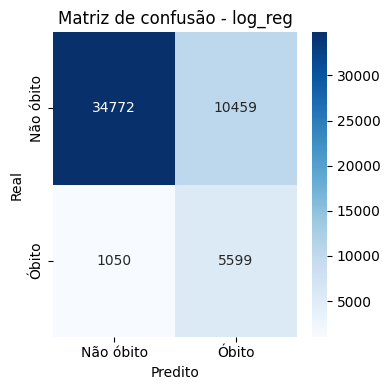

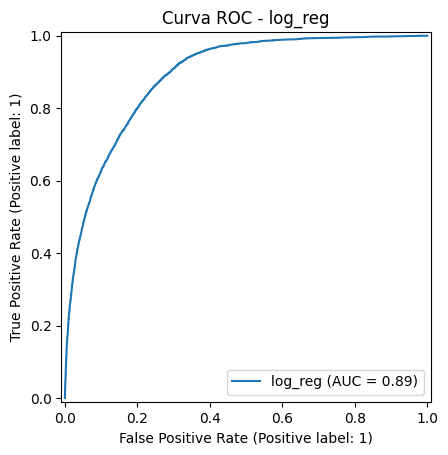

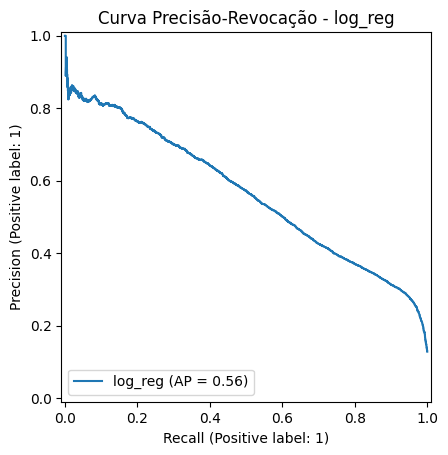

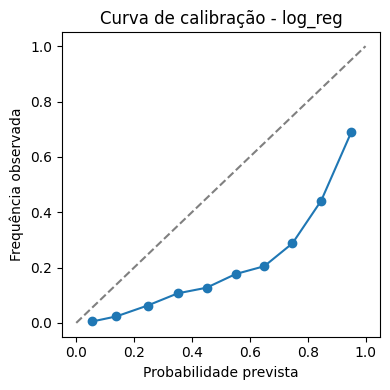


=== random_forest ===

Métricas de teste:
       roc_auc: 0.8969
        pr_auc: 0.5828
      accuracy: 0.7973
  balanced_acc: 0.8118
        recall: 0.8313
     precision: 0.3704
            f1: 0.5124
         brier: 0.1251

Relatório de classificação (teste):
              precision    recall  f1-score   support

         0.0      0.970     0.792     0.872     45231
         1.0      0.370     0.831     0.512      6649

    accuracy                          0.797     51880
   macro avg      0.670     0.812     0.692     51880
weighted avg      0.893     0.797     0.826     51880



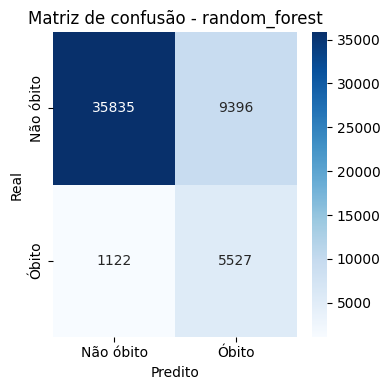

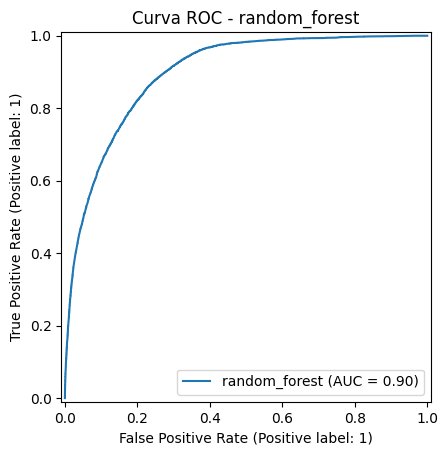

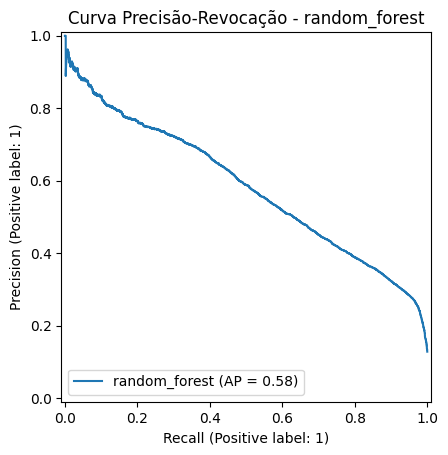

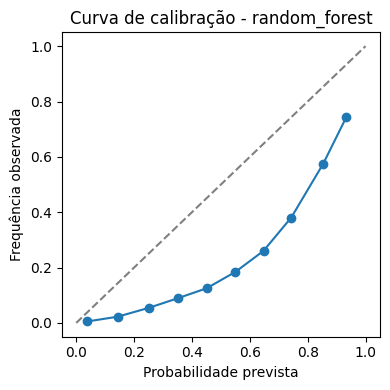

,roc_auc,pr_auc,accuracy,balanced_acc,recall,precision,f1,brier
log_reg,0.890343,0.564965,0.778161,0.805423,0.842082,0.348674,0.493152,0.139792
random_forest,0.896925,0.582846,0.797263,0.811760,0.831253,0.370368,0.512424,0.125082


In [43]:
# ## 6. Rodar e comparar modelos

# %%
resultados = {}

for nome, modelo in modelos.items():
    m = avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test)
    resultados[nome] = m

pd.DataFrame(resultados).T

## Modelos de Machine Learning para evolução (óbito vs. não óbito)

---

### 1. Formulação do problema

**Tarefa**

Prever a evolução de casos de SRAG hospitalizados (`EVOLUCAO_BIN`), definida como:

- `0` = cura  
- `1` = óbito  

a partir de características clínicas, demográficas, de comorbidades e de gravidade registradas na notificação.

**Amostra utilizada**

- Base: `df_tipado.csv`  
- Inclusão: apenas registros com `EVOLUCAO_disponivel = 1`.

**Desbalanceamento**

- ~**13%** dos casos evoluem para **óbito** (classe positiva).  
- ~**87%** evoluem para **não óbito**.

**Objetivo prático**

Desenvolver modelos capazes de **identificar pacientes com maior risco de óbito**, aceitando maior número de falsos positivos, desde que:

- o modelo seja **estável**,  
- **interpretável** do ponto de vista clínico,  
- e útil como **ferramenta de apoio à decisão**, não como critério único.

---

### 2. Variáveis preditoras

A seleção de variáveis (`features`) foi guiada pela EDA, priorizando:

- **Relevância clínica**,  
- **Boa completude de preenchimento**,  
- **Associação clara com o desfecho** na análise descritiva.

#### 2.1 Variáveis numéricas principais

- `NU_IDADE_N` – idade em anos.  
- `N_COMORB` – número total de comorbidades presentes.  
- `HAS_COMORB` – indicador binário de presença de pelo menos uma comorbidade (0/1).  
- `SEVERIDADE_ESCALA` – escala ordinal de gravidade:
  - `0` = sem UTI e sem suporte ventilatório  
  - `1` = UTI sem ventilação  
  - `2` = ventilação não invasiva  
  - `3` = ventilação invasiva  
- `dias_sin_interna_cl` – dias entre início dos sintomas e internação (variável tratada/limpa).  
- `dias_sin_uti_cl` – dias entre início dos sintomas e entrada na UTI (variável tratada/limpa).

#### 2.2 Variáveis categóricas principais

**Demografia e território**

- `CS_SEXO_label` – sexo biológico.  
- `CS_RACA_macro` – Branca / Preta/Parda / Outras / Ignorado.  
- `CS_ZONA_label` – zona de residência (urbana / rural / periurbana / missing).  
- `SG_UF_NOT` – UF de notificação.  
- `REGIAO` – macrorregião (N, NE, CO, SE, S).  
- `TIPO_MUN` – capital / interior.  
- `estacao` – estação do ano (verão / outono / inverno / primavera).

**Comorbidades (todas binárias: 0 = ausente, 1 = presente)**

- `PUERPERA`, `CARDIOPATI`, `HEMATOLOGI`, `SIND_DOWN`, `HEPATICA`,  
- `ASMA`, `DIABETES`, `NEUROLOGIC`, `PNEUMOPATI`, `IMUNODEPRE`,  
- `RENAL`, `OBESIDADE`, `OUT_MORBI`.

**Gravidade e suporte**

- `UTI_flag` – uso de UTI (1 = usou, 0 = não).  
- `SUPORT_VEN` – categoria de suporte ventilatório (invasivo / não invasivo / sem suporte).

#### 2.3 Pré-processamento

- **Numéricas**: imputação por **mediana** + **padronização** (z-score).  
- **Categóricas**: imputação por **moda** + **One-Hot Encoding (OHE)**.  
- **Divisão treino-teste**:  
  - 80% treino / 20% teste,  
  - divisão **estratificada** pelo desfecho (`EVOLUCAO_BIN`).

---

### 3. Modelos testados

Foram ajustados dois modelos de classificação binária supervisionada, compartilhando o mesmo `ColumnTransformer` de pré-processamento.

#### 3.1 Regressão Logística

- `class_weight = "balanced"` para compensar o desbalanceamento da classe positiva.  
- Vantagens:
  - Interpretação direta dos coeficientes em termos de **odds** e **efeitos marginais**.  
  - Melhor perfil de **calibração** em comparação com modelos de árvore, em geral.

#### 3.2 Random Forest

- `n_estimators = 300`.  
- `min_samples_split = 10`, `min_samples_leaf = 5`.  
- `class_weight = "balanced"`.  
- Foco em capturar **relações não lineares** e **interações** entre as variáveis.

**Avaliação**

- Avaliação realizada em conjunto de teste **hold-out** (20%).  
- Não foi realizado *hyperparameter tuning* agressivo;  
  o foco foi **transparência e robustez**, e não otimizar marginalmente indicadores como a AUC.

---

### 4. Resultados principais

#### 4.1 Métricas globais (conjunto de teste)

| Modelo               | ROC-AUC | PR-AUC | Accuracy | Balanced Acc | Recall (óbito) | Precision (óbito) | F1 (óbito) | Brier |
|----------------------|:-------:|:------:|:--------:|:------------:|:--------------:|:-----------------:|:----------:|:-----:|
| Regressão Logística  | 0,890   | 0,565  | 0,778    | 0,805        | 0,842          | 0,349             | 0,493      | 0,140 |
| Random Forest        | 0,897   | 0,583  | 0,797    | 0,812        | 0,831          | 0,370             | 0,512      | 0,125 |

**Leitura sintética**

- Ambos os modelos apresentam desempenho **elevado**:
  - **ROC-AUC ~0,89–0,90** → boa capacidade de separar óbito vs. não óbito.  
  - **PR-AUC ~0,56–0,58**, bem acima da prevalência (~0,13) → bom desempenho especificamente na classe rara (óbito).
- O **Random Forest** apresenta:
  - **Acurácia** e **balanced accuracy** ligeiramente maiores.  
  - **F1** e **precisão** para óbito um pouco superiores, com **recall** levemente menor em relação à Regressão Logística.

#### 4.2 Matrizes de confusão (limiar padrão 0,5)

**Regressão Logística**

- Verdadeiro Não Óbito (`0`):
  - **TN** = 34.772  
  - **FP** = 10.459  
- Verdadeiro Óbito (`1`):
  - **FN** = 1.050  
  - **TP** = 5.599  

**Random Forest**

- Verdadeiro Não Óbito (`0`):
  - **TN** = 35.835  
  - **FP** = 9.396  
- Verdadeiro Óbito (`1`):
  - **FN** = 1.122  
  - **TP** = 5.527  

**Interpretação clínica**

- Ambos os modelos capturam cerca de **83–84%** dos óbitos (**recall elevado**).  
- O Random Forest realiza um pequeno *trade-off*:
  - Reduz levemente a sensibilidade (recall),  
  - Reduz o número de falsos positivos, aumentando a **precisão** e a **acurácia** global.  

Em termos operacionais, os modelos são relativamente **liberais em sinalizar risco de óbito** (muitos FPs), o que é consistente com cenários de **triagem clínica**, desde que o fluxo de uso dos alertas seja bem desenhado.

---

### 5. Curvas ROC, PR e calibração

#### 5.1 Curvas ROC

- Ambas as curvas permanecem bem acima da diagonal (linha de não discriminação).  
- O trecho inicial (baixa taxa de falso positivo – FPR) já apresenta **taxa de verdadeiro positivo (TPR) elevada**, o que é desejável quando se busca **alto recall** com custo aceitável de falsos positivos.

#### 5.2 Curvas Precisão–Revocação (PR)

- As curvas se mantêm **acima do baseline** definido pela prevalência da classe positiva.  
- Permitem seleção de limiares de decisão com:
  - **Recall ~0,8–0,9**,  
  - **Precisão na faixa de 0,3–0,4**,  
  o que é compatível com uso em **sistemas de alerta de risco**.

#### 5.3 Calibração

**Random Forest**

- Tendência a **subestimar o risco** nas faixas intermediárias (probabilidades previstas < 0,7).  
- No estrato de maior risco previsto (probabilidades > ~0,9), a frequência observada de óbito situa-se em torno de **70–75%**, indicando um grupo de **altíssimo risco**, embora ainda com calibração imperfeita.

**Regressão Logística**

- Por construção, apresenta perfis de calibração geralmente **mais estáveis**,  
  ainda que com **desvios nas caudas** (probabilidades muito altas ou muito baixas).

**Aplicação prática**

- O **Random Forest** pode ser utilizado como **motor de ranqueamento de risco** (definir quem merece avaliação prioritária).  
- Caso seja necessário utilizar probabilidades como estimativas mais “fiéis” de risco absoluto, pode-se aplicar **calibração adicional** (*Platt scaling* ou **Isotonic Regression**).

---

### 6. Interpretação: o que o modelo parece estar “vendo”?

Mesmo antes de análises formais de interpretabilidade (ex.: SHAP, feature importance), a combinação entre EDA e definição das variáveis permite algumas inferências:

- **Idade** e **número de comorbidades** emergem como determinantes centrais do risco de óbito.  
- **Marcadores de gravidade** na admissão (uso de UTI, suporte ventilatório, escala de gravidade) estão entre os blocos mais preditivos:
  - Pacientes em **ventilação invasiva** apresentam risco médio de óbito próximo de **50%**, o que é refletido claramente nas previsões.  
- **Território e macro-raça** funcionam como variáveis de ajuste:
  - As diferenças observadas de letalidade por região, zona e raça na EDA ajudam a refinar o risco,
  - mas não superam, em importância, o conjunto **idade + carga de comorbidades + gravidade clínica**.  
- Variáveis de **tempo** (dias entre início de sintomas e internação/UTI) têm efeito mais sutil, mas contribuem para identificar quadros de **chegada tardia ao serviço**, associada a pior prognóstico.

**Síntese interpretativa**

O modelo aprendeu uma narrativa coerente com a EDA:  
**idade avançada**, **múltiplas comorbidades**, **alta gravidade na admissão** e alguns contextos territoriais menos favoráveis formam o núcleo dos casos com **risco elevado de óbito**.

---

### 7. Por que não temos (e nem queremos) um modelo “perfeito”

Mesmo com **ROC-AUC ~0,90**, permanecem limitações relevantes:

- Cerca de **16–17% dos óbitos** não são identificados com o limiar padrão de 0,5 (falsos negativos).  
- As probabilidades previstas não são perfeitamente calibradas, especialmente nos extremos.

Essas limitações não são meramente “defeitos de algoritmo”, mas refletem:

#### 7.1 Informação ausente na base

- Ausência de variáveis críticas como:
  - Tipo viral confirmado para todos os casos,  
  - Carga viral,  
  - Parâmetros laboratoriais (ex.: gasometria, lactato),  
  - Detalhes completos do tratamento,  
  - Tempo exato até início de suporte avançado.  
- Alta probabilidade de **ruído no rótulo** (`EVOLUCAO_BIN`), por:
  - classificações inconsistentes,  
  - óbitos por outras causas,  
  - erros de registro.

#### 7.2 Heterogeneidade assistencial

- Um mesmo perfil clínico pode ter desfechos diferentes em função de:
  - disponibilidade de leitos de UTI,  
  - estrutura de serviços,  
  - protocolos locais,  
  - experiência da equipe.  

Isso gera **variabilidade não explicada** que o modelo não tem como capturar com as variáveis disponíveis.

#### 7.3 Processos dinâmicos

- O manejo de SRAG evolui ao longo do tempo:
  - mudanças em protocolos,  
  - campanhas,  
  - variação do mix de vírus circulantes.  

O modelo enxerga um **recorte estático** (snapshot) e tenta resumir uma realidade que é **dinâmica**, o que naturalmente impõe limites à capacidade preditiva.

---

### Conclusão

Os modelos desenvolvidos apresentam **bom desempenho discriminatório** e comportamento coerente com a epidemiologia observada na EDA, especialmente em relação a:

- **Idade**,  
- **Carga de comorbidades**,  
- **Marcadores de gravidade**,  
- e determinantes territoriais.

No entanto, a previsão de óbito em SRAG é, por natureza, um problema **ruidoso** e **incompleto** do ponto de vista de dados. Assim, esses modelos devem ser entendidos como **ferramentas de apoio à decisão clínica e de gestão**, úteis para **estratificação e priorização de casos**, e não como instrumentos determinísticos ou substitutos do julgamento profissional.


### Próximas etapas recomendadas

1. **Score de risco na admissão (uso assistencial do modelo)**
   - Implementar o modelo (preferencialmente o Random Forest, com a Regressão Logística como baseline explicável) para gerar, nas primeiras 24h de internação, uma **probabilidade de óbito** por paciente.
   - Definir **faixas de risco** operacionais, por exemplo:
     - **Baixo risco:** p < 10%  
     - **Risco intermediário:** 10% ≤ p < 30%  
     - **Alto risco:** p ≥ 30%
   - Associar as faixas a **ações concretas**, como:
     - Revisão de caso por equipe multiprofissional.
     - Checagem de elegibilidade para protocolos específicos (antivirais, suporte intensivo).
     - Priorização em monitoramento e alocação de leitos de maior complexidade.

2. **Monitoramento de inequidades e possíveis vieses do modelo**
   - Avaliar desempenho do modelo **estratificado por:**
     - Região (`REGIAO`), UF (`SG_UF_NOT`), zona (`CS_ZONA_label`), tipo de município (`TIPO_MUN`), macro-raça (`CS_RACA_macro`).
   - Acompanhar métricas como **recall, FPR, FNR e calibração** em cada grupo:
     - Grupos com **maior FNR (óbitos não identificados)** sugerem risco de subatenção/viés.
     - Diferenças grandes de calibragem entre grupos podem indicar problemas de qualidade de registro ou acesso desigual.
   - Usar esses achados para:
     - Ajustar o modelo (reponderação, reamostragem).
     - Discutir melhorias de fluxo assistencial e registro em áreas/grupos mais críticos.

3. **Gestão de capacidade assistencial**
   - Utilizar o score para criar um **indicador agregado** por hospital / região:
     - % de pacientes internados em faixa de **alto risco**.
     - Evolução desse indicador **ao longo do tempo** (semanal / mensal).
   - Integrar esse indicador ao planejamento de:
     - **Leitos de UTI** e suporte ventilatório.
     - Distribuição de profissionais e insumos (medicação, equipamentos).
   - Em cenários de pico sazonal, usar o modelo como **radar antecipado**:
     - Aumento de pacientes em alto risco sem ampliação de capacidade → alerta de possível saturação.

4. **Refinamento técnico do modelo**
   - **Calibração explícita** das probabilidades (Platt scaling ou isotonic regression) usando conjunto de validação, para que o score possa ser interpretado como risco absoluto aproximado.
   - **Validação temporal:** treinar em parte do ano e testar em períodos posteriores para avaliar estabilidade frente a mudanças de sazonalidade e circulação de vírus.
   - **Validação externa:** aplicar o modelo em dados de outros anos/hospitais, quando disponíveis, para verificar generalização.
   - Analisar **importância de variáveis / SHAP values** para:
     - Transparência com equipes clínicas.
     - Identificar combinações de fatores de risco não triviais (ex.: idade + zona rural + atraso na internação).

5. **Melhoria de dados e integração em fluxo real**
   - Priorizar melhoria de **campos críticos** para o modelo:
     - Comorbidades, datas (início de sintomas, internação, UTI), suporte ventilatório, evolução.
   - Criar rotinas de **qualidade de dado** (alertas de inconsistência, campos obrigatórios em sistemas de notificação).
   - Planejar a integração do modelo em:
     - Sistemas de prontuário / regulação de leitos.
     - Dashboards de vigilância com camadas: **epidemiologia + risco individual**.

6. **Avaliação de impacto**
   - Se o modelo for usado em campo, desenhar um **piloto controlado**:
     - Monitorar se o uso do score:
       - Reduz atraso em intervenções em pacientes de alto risco.
       - Melhora desfechos (óbito, tempo de UTI) em comparação a períodos sem score.
   - Documentar lições aprendidas para orientar uma possível **escalação nacional** ou regional do uso do modelo.



In [44]:
import os
import joblib

# === 1. Dados finais para treino ===

feature_cols = numeric_features + categorical_features

X_full = df_model[feature_cols].copy()
y_full = df_model[TARGET_COL].copy()

print(X_full.shape, y_full.shape)

# === 2. Treinar modelos finais em TODO o conjunto (treino + teste) ===

modelos_treinados = {}

for nome, modelo in modelos.items():
    print(f"Treinando modelo final: {nome} ...")
    modelo.fit(X_full, y_full)
    modelos_treinados[nome] = modelo

# === 3. Salvar em .pkl ===

os.makedirs("models", exist_ok=True)

for nome, modelo in modelos_treinados.items():
    caminho = os.path.join("models", f"{nome}_srag_2023.pkl")
    joblib.dump(modelo, caminho)
    print(f"Modelo salvo em: {caminho}")


(259396, 20) (259396,)
Treinando modelo final: log_reg ...
Treinando modelo final: random_forest ...
Modelo salvo em: models\log_reg_srag_2023.pkl
Modelo salvo em: models\random_forest_srag_2023.pkl
